In [7]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC  # <--- Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- SETUP OUTPUT DIRECTORY ---
# We save this to the same 'NV' folder
OUTPUT_DIR = config.MODELS_DIR / "advanced" / "NV"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Setup Complete. Artifacts will be saved to: {OUTPUT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete. Artifacts will be saved to: /content/drive/MyDrive/NFL_Prediction_System/models/advanced/NV


In [8]:
# 2. Load Data & Define Features (NO VEGAS)
print("Loading Data...")
features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')

TARGET = 'home_win'
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
    'spread_line', 'total_line' # <--- PURE FOOTBALL ONLY
]
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

Loading Data...


In [9]:
# 3. Split
TEST_SEASON = 2023
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

In [10]:
# 4. Scale (ABSOLUTELY CRITICAL FOR SVM)
# SVM calculates 'distances' between points. If you don't scale,
# a feature like "Passing Yards" (300) will drown out "Turnovers" (2).
print("Scaling Data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling Data...


In [11]:
# 5. Train Support Vector Machine
print(f"{'-'*30}\nTraining SVM (NV)...")

# SVC Parameters
svm_model = SVC(
    kernel='rbf',          # 'Radial Basis Function' - wraps around data clusters
    C=1.0,                 # Regularization (1.0 is standard; lower = smoother)
    gamma='scale',         # Auto-calculates kernel coefficient
    probability=True,      # REQUIRED for Voting Ensemble (makes it output %)
    random_state=42,
    verbose=True           # Prints progress
)

svm_model.fit(X_train_scaled, y_train)
print("\n✅ Training Complete.")

------------------------------
Training SVM (NV)...
[LibSVM]
✅ Training Complete.


------------------------------
Evaluation Results...
📐 SVM NV Accuracy: 58.09%


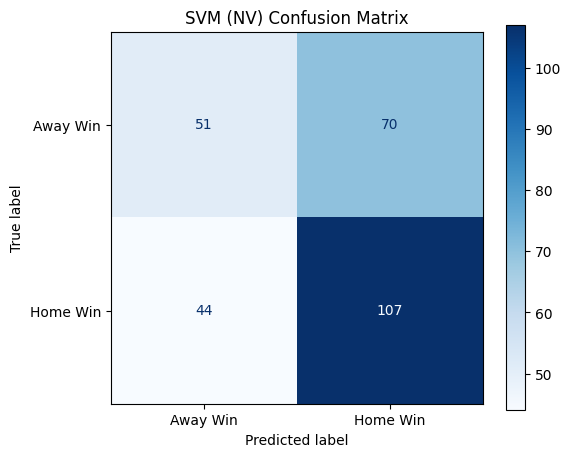

✅ Saved SVM model to /content/drive/MyDrive/NFL_Prediction_System/models/advanced/NV


In [12]:
# 6. Evaluate
print(f"{'-'*30}\nEvaluation Results...")
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"📐 SVM NV Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Away Win', 'Home Win'], cmap='Blues', ax=ax)
plt.title("SVM (NV) Confusion Matrix")
plt.show()

# Save
with open(OUTPUT_DIR / "nv_svm_model.pkl", 'wb') as f:
    pickle.dump(svm_model, f)
print(f"✅ Saved SVM model to {OUTPUT_DIR}")